In [3]:
import numpy as np
from context import samplers as samplers

import matplotlib.pyplot as plt
# import importlib
# importlib.reload(samplers)


2.7
lambda  2.7


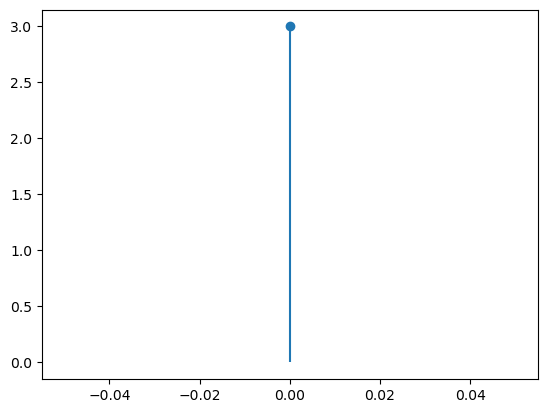

In [4]:
p = 1 #signal dimension
m = 2 #number of measurements

x0 = np.random.randn(p,)
x0[np.random.permutation(p)[:9*p//10] ]=np.zeros(9*p//10,)
A = np.random.randn(m,p)/np.sqrt(m)/4
x0 = x0+2
x0 = x0*0+3
# x0 = [2,0]
A = np.ones((1,1))
# eps = 4
# A = np.array([[1, 1],[ 1, 1+eps]])
y = A@x0
lam = np.max(np.abs(A.T@y))*.9
print(lam)
# lam = 0.1


print('lambda ', lam)
plt.stem(x0)


fval = lambda x: np.linalg.norm(A@x - y)**2 * 0.5
grad = lambda x: A.T@(A@x - y)

# lam = .1
beta = 1


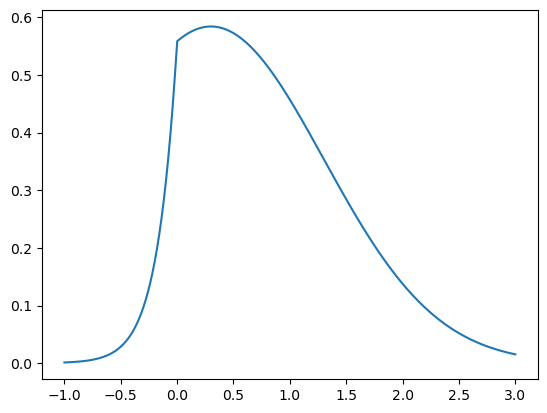

In [5]:
from scipy import integrate
# get true density via numerical integration 
def f(x):
    return np.exp(-(fval(np.array([x]))+lam*np.abs(x))*beta)
Total_mass = integrate.quad(f, -np.inf, np.inf)[0]
# print(Total_mass)
density = lambda x: f(x)/Total_mass
mean_true = integrate.quad(lambda x: x**2*f(x), -np.inf, np.inf)[0]/Total_mass
def rho(xgrid):
    return np.array([density(t) for t in xgrid])
grid = np.linspace(-1,3,1000)
plt.plot(grid,rho(grid))




In [47]:
Lf = np.linalg.norm(A.T@A, 2)
gamma= 1/Lf/20
# gamma= 1/Lf/100

tau = gamma/5/(Lf*gamma+1)
tau

phi = lambda x: x**2

In [48]:
method_list = []
sample_list = []
time_list = []
import time

n_exp = 6
m_exp = 5
n = 5*10**n_exp #number of samples  to generate
burn_in = 10**m_exp #number of burn in samples

def soft(x,tau): 
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)
grad_F = lambda x:  grad(x) + (x - soft(x,lam*gamma))/gamma

#Run proximal langevin
print('Running prox-l1 sampler ...\n')
name = 'Prox-l1'
Iterate = lambda x: samplers.one_step_langevin(x,p, grad_F, tau,beta)

J0 = 0
J =8
mean_prox = []
for j in range(J0,J):
    gamma= 1/Lf/2**j
    tau = gamma/2/(Lf*gamma+1)
    xinit = np.random.randn(p,)
    print(j)
    n *=2
    n= int(n)
    burn_in *=2
    samples_proxl1 = samplers.generate_samples_x(Iterate, xinit, n ,burn_in)
    mean_prox.append( np.mean(phi(samples_proxl1),axis=0))
    # mean_prox.append( np.mean(np.exp(-(samples_proxl1-1)**2),axis=0))

# plt.savefig('results/rate_images_prox.pdf', bbox_inches='tight')

 

Running prox-l1 sampler ...

0
1
2
3
4
5
6
7


In [49]:
n = 10**n_exp #number of samples  to generate
burn_in = 10**m_exp #number of burn in samples
# J =12


print('Running UV sampler ... \n')
name = 'Hadamard'
Iterate = lambda x: samplers.one_step_hadamard(x, p,grad, tau, lam,beta)


mean_uv = []
for j in range(J0,J):
    gamma= 1/Lf/2**j
    tau = gamma/2/(Lf*gamma+1)
    print('j:', j, 'tau:', tau)
    uinit = np.random.rand(p,)
    vinit = np.random.randn(p,)
    uvinit = np.concatenate((uinit,vinit))
    n *=2
    n= int(n)
    burn_in *=2
    samples_uv = samplers.generate_samples_x(Iterate, uvinit, n, burn_in)
    samples_x_uv = samples_uv[:,:p]*samples_uv[:,p:]
    mean_uv.append( np.mean(phi(samples_x_uv),axis=0))
    # mean_uv.append( np.mean(np.exp(-(samples_x_uv-1)**2),axis=0))

# plt.savefig('results/rate_images_uv.pdf', bbox_inches='tight')



Running UV sampler ... 

0.25
0
0.16666666666666666
1
0.1
2
0.05555555555555555
3
0.029411764705882353
4
0.015151515151515152
5
0.007692307692307693
6
0.003875968992248062
7


In [50]:
tau_arr = []
for j in range(J0,J):
    gamma= 1/Lf/2**j
    tau_arr.append(  gamma/5/(Lf*gamma+1))

tau_arr = np.array(tau_arr)


In [74]:
with open('save11Nov.npy', 'rb') as f:
    tau_arr = np.load(f)
    mean_uv = np.load(f)
    mean_true = np.load(f)
    mean_prox = np.load(f)


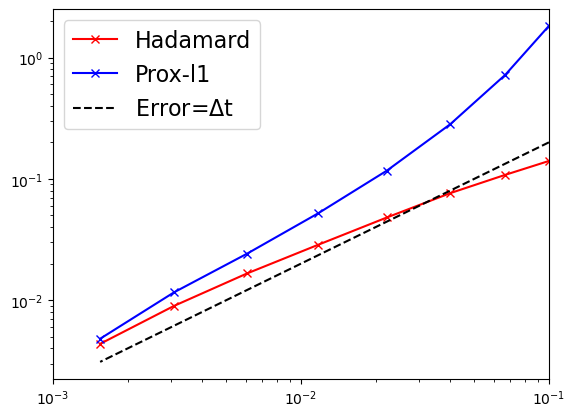

In [81]:

plt.loglog(tau_arr, np.abs(np.array(mean_uv)-mean_true),'rx-',label='Hadamard')
plt.loglog(tau_arr, np.abs(np.array(mean_prox)-mean_true),'bx-',label='Prox-l1')
plt.loglog(tau_arr,tau_arr*2,'k--',label='Error=$\Delta$t')
# plt.xlabel('$\Delta t$')
# plt.ylabel('Error')
plt.xlim([1e-3,1e-1])
plt.legend(fontsize=16)
plt.savefig('results/rate_potentialError.pdf', bbox_inches='tight')

In [59]:
with open('save11Nov.npy', 'wb') as f:
    np.save(f, tau_arr)
    np.save(f, mean_uv)
    np.save(f, mean_true)
    np.save(f, mean_prox)

In [60]:
def generate_samples_x(Iterate,init, n, phi):
    x = init
    record = []
    for i in range(n):
        x = Iterate(x)       
        record.append(phi(x))
    return np.array(record),x


def soft(x,tau): 
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)

def one_step_proxl1(x,p,K, grad, tau, lam, beta=1):
    G =  grad(x) + (x - soft(x,lam*gamma))/gamma
    y = x - tau*G + np.sqrt(2*tau/beta)*np.random.randn(p,K)
    return y



def one_step_hadamard(x, p, K, grad, tau, lam,beta=1):  

    u = x[:p]
    v = x[p:]

    g = grad(u*v)
    Grad = np.concatenate((v*g, u*g))
    z = x - tau*Grad + np.random.randn(2*p,K)*np.sqrt(2*tau/beta)
    z[:p] = (z[:p]+np.sqrt(z[:p]**2 + 4*tau/beta*(1+tau*lam)))/2
    x_ = z/(1+tau*lam)
    return x_


In [61]:
j=10
gamma= 1/Lf/2**j
tau = gamma/2/(Lf*gamma+1)
print(tau)
K=50000
n_exp =  4
n = 10**n_exp #number of samples  to generate
burn_in = 0 #number of burn in samples
beta=1
xinit = np.random.rand(p,K)*0

y1 = np.tile(y[:,None],(1,K))
phi = lambda x: np.mean(x**2,1)

grad = lambda x: A.T@(A@x - y1)
Iterate = lambda x: one_step_proxl1(x,p,K, grad, tau, lam, beta=beta)

n= int(n)
phi = lambda x: np.mean(x**2,1)
mean_l1,x = generate_samples_x(Iterate, xinit, n ,phi)



0.0004878048780487805


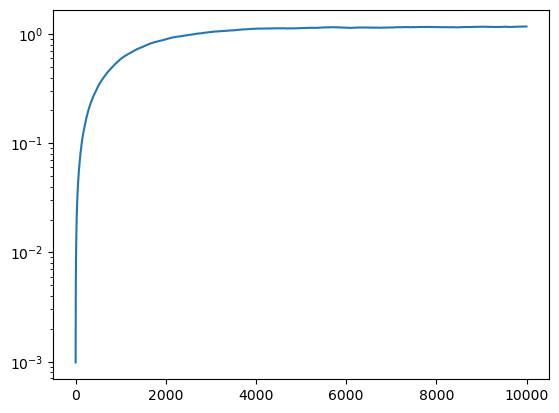

In [62]:
plt.semilogy(np.abs(mean_l1))

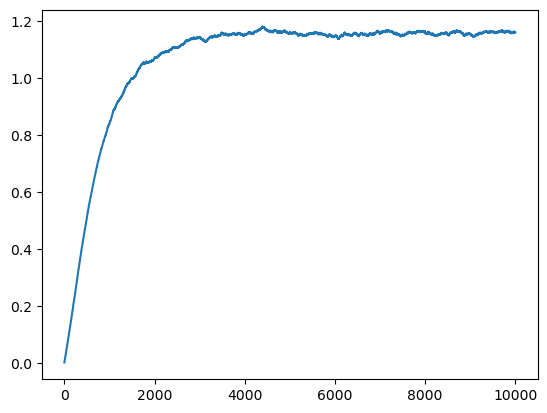

In [63]:

uvinit = np.ones((p*2,K))*1
uvinit[p:,:] = np.zeros((p,K))
Iterate = lambda x: one_step_hadamard(x, p,K,grad, tau, lam,beta)


n= int(n)
phi_uv = lambda x: phi( x[:p,:]*x[p:,:])
mean_uv,x = generate_samples_x(Iterate, uvinit, n ,phi_uv)
plt.plot(np.abs(mean_uv))

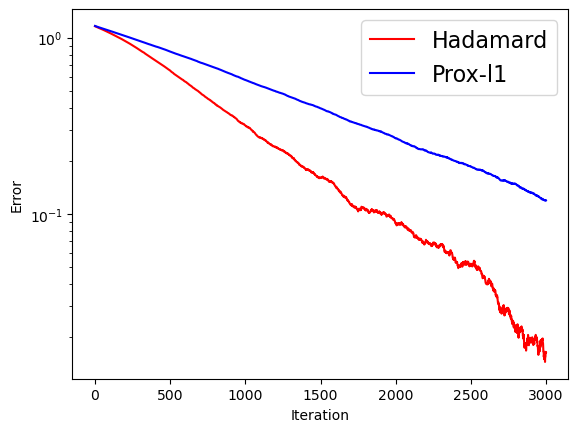

In [65]:
a = 0.3

plt.semilogy(np.abs(mean_uv[:int(a*n)]-np.mean(mean_uv[-1000:])),'r',label='Hadamard')
plt.semilogy(np.abs(mean_l1[:int(a*n)]-np.mean(mean_l1[-1000:])),'b',label='Prox-l1')
# plt.semilogy([0,1e6],[mean_true,mean_true], 'r')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend(fontsize=16)
plt.savefig('results/rate_fixedstep3.pdf', bbox_inches='tight')

In [627]:
# 
running_mean_uv = np.cumsum((mean_uv)) / (np.arange(len(mean_uv)) + 1)
running_mean_l1 = np.cumsum((mean_l1)) / (np.arange(len(mean_l1)) + 1)

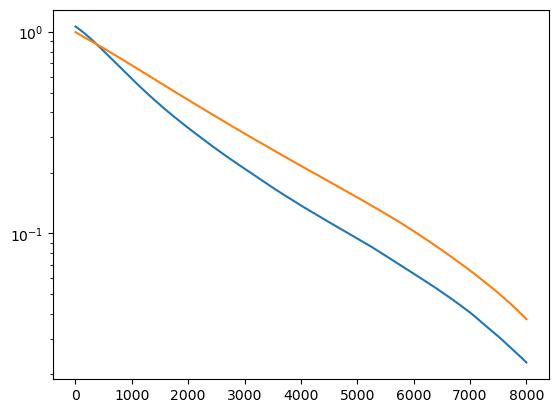

In [628]:
a = 0.8
plt.semilogy(np.abs(running_mean_uv[:int(a*n)]-running_mean_uv[-1]))
plt.semilogy(np.abs(running_mean_l1[:int(a*n)] -running_mean_l1[-1]))

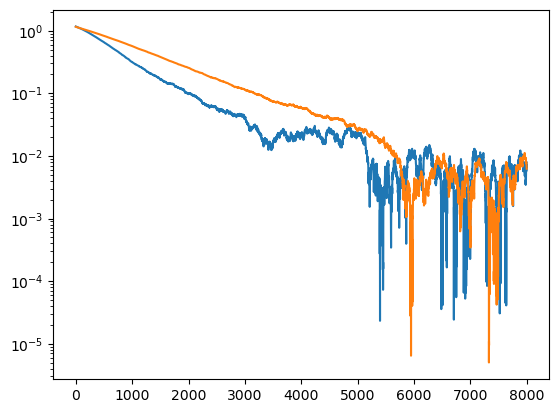

In [629]:

plt.semilogy(np.abs(mean_uv[:int(a*n)]-np.mean(mean_uv[-10:])),label='Hadamard')
plt.semilogy(np.abs(mean_l1[:int(a*n)]-np.mean(mean_l1[-10:])),label='Prox-l1')

In [540]:
np.mean(mean_uv[-10:]),np.mean(mean_l1[-10:])

(0.8176710586333238, 0.8187977417871772)